### **Data Preparation**

**Import library**

In [8]:
import random
import os
import numpy as np
import joblib
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import time
import tracemalloc
from sklearn.svm import SVC
from tensorflow import keras
from datetime import datetime
from google.colab import drive
from sklearn.model_selection import GridSearchCV
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dropout, Dense, BatchNormalization
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

**Inisialisasi seed**

In [9]:
# setting seed agar mendapat hasil akurasi yang lebih konsisten
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

**Menghubungkan Google Colab dengan Dataset di Goole Drive**

In [15]:
drive.mount("/content/drive")
data_dir = "/content/drive/MyDrive/dataset"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Menghubungkan filepath untuk menyimpan model**

In [16]:
# Definisikan path untuk menyimpan model CNN
checkpoint_dir = '/content/drive/MyDrive/dataset/Hasil'

# Fungsi untuk menyimpan model CNN
def save_keras_model(model, model_name, test_accuracy):
    timestamp = datetime.now().strftime("%Y%m%d")
    checkpoint_name = f"{model_name}_acc_{test_accuracy:.2f}_{timestamp}.h5"
    checkpoint_path = os.path.join(checkpoint_dir, checkpoint_name)
    model.save(checkpoint_path)
    print(f"Model disimpan di {checkpoint_path}")

**Inisialisasi parameter default**

In [17]:
# inisialisasi batch size dan image size (height & weight)
batch_size = 32
img_height = 224
img_width = 224

**Data preparation**

In [18]:
# Muat dataset dari directory
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Tampilkan semua kelas dari dataset
class_names = dataset.class_names
print("Nama Kelas pada Dataset: ", class_names)

Found 610 files belonging to 8 classes.
Nama Kelas pada Dataset:  ['kupu_batik_cap', 'kupu_harimau_kuning_hijau', 'kupu_hijau_biru', 'kupu_jarak', 'kupu_jojo', 'kupu_pantat_merah', 'kupu_raja_helena', 'kupu_raja_limau']


**Visualisasi jumlah data di tiap kelas**


Jumlah data tiap kelas:
kupu_batik_cap: 100 gambar
kupu_harimau_kuning_hijau: 100 gambar
kupu_hijau_biru: 100 gambar
kupu_jarak: 7 gambar
kupu_jojo: 100 gambar
kupu_pantat_merah: 95 gambar
kupu_raja_helena: 8 gambar
kupu_raja_limau: 100 gambar


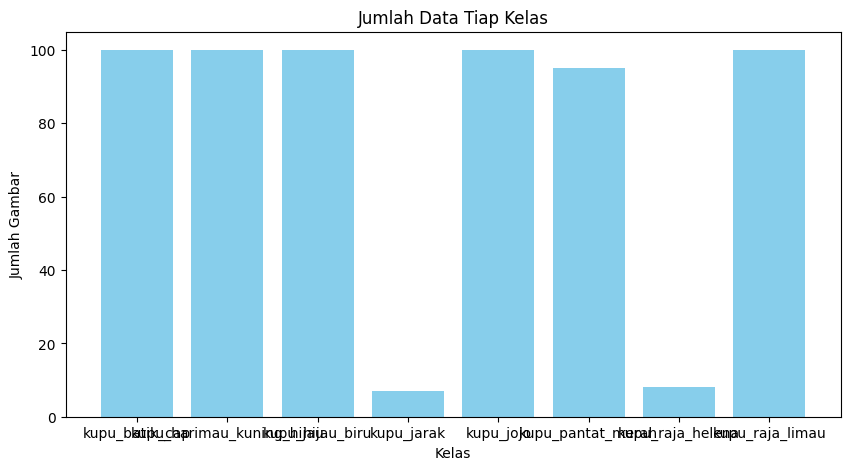

In [19]:
# Inisialisasi variabel class_counts untuk menyimpan jumlah data tiap kelas
class_counts = {class_name: 0 for class_name in class_names}

# Hitung jumlah data tiap kelas
for images, labels in dataset:
    for label in labels:
        class_counts[class_names[label]] += 1

# Tampilkan jumlah data tiap kelas
print("\nJumlah data tiap kelas:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} gambar")

# Visualisasi jumlah data tiap kelas menggunakan chart bar
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title('Jumlah Data Tiap Kelas')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Gambar')
plt.show()

**Tampilkan gambar di tiap kelas**

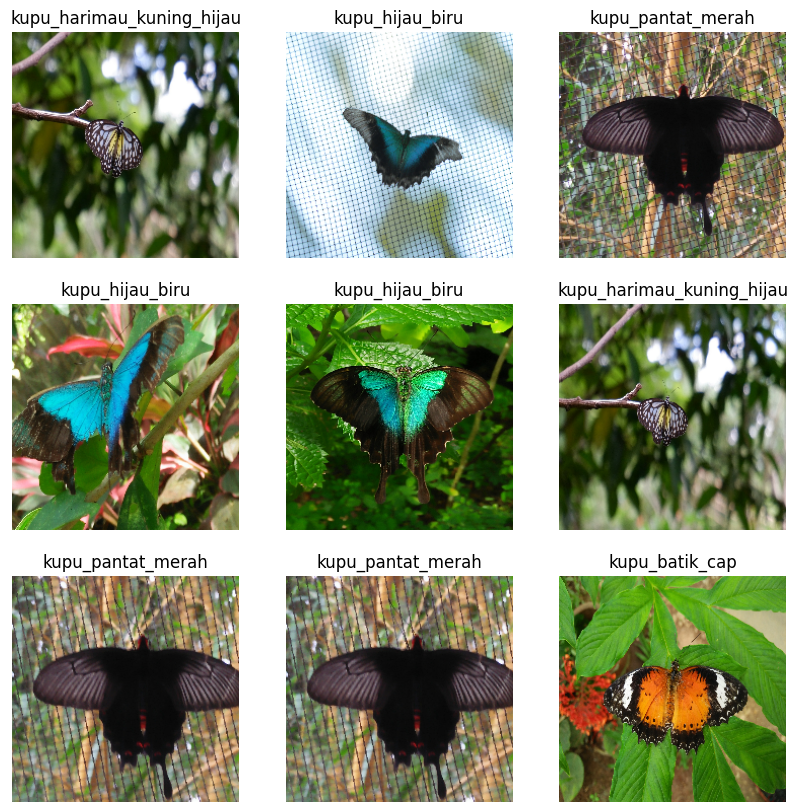

In [20]:
# visualisasi data tiap kelas dataset
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
    for i in range(min(9, len(images))):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

### **Preprocessing**

**Split data menjadi 3 pembagian**

In [21]:
# Pembagian data training -> 70%
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,  # 70% untuk training
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Pembagian data validasi dan testing -> 30%
val_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Pembagian data validasi  -> 15%
val_ds = val_test_ds.take(len(val_test_ds) // 2)

# Pembagian data testing -> 15%
test_ds = val_test_ds.skip(len(val_test_ds) // 2)

Found 610 files belonging to 8 classes.
Using 427 files for training.
Found 610 files belonging to 8 classes.
Using 183 files for validation.


**Hitung jumlah gambar di masing-masing proporsi data**

In [22]:
num_train_files = sum([len(labels) for images, labels in train_ds])
num_val_files = sum([len(labels) for images, labels in val_ds])
num_test_files = sum([len(labels) for images, labels in test_ds])

print(f"Jumlah Data di Dataset Training: {num_train_files}")
print(f"Jumlah Data di Dataset Validasi: {num_val_files}")
print(f"Jumlah Data di Dataset Testing: {num_test_files}")

Jumlah Data di Dataset Training: 427
Jumlah Data di Dataset Validasi: 96
Jumlah Data di Dataset Testing: 87


**Augmentasi dan normalisasi data menggunakan ImageDataGenerator**

In [23]:
# Augmentasi dan Normalisasi data training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Normalisasi data validasi
val_datagen = ImageDataGenerator(rescale=1./255)

# Normalisasi data testing
test_datagen = ImageDataGenerator(rescale=1./255)

### **Pembuatan Model**

Menerapkan arsitektur DenseNet121 tanpa lapisan atas (Fully Connected Layer)

In [26]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, BatchNormalization, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Hyperparameter
learning_rate = 0.0001

# Menerapkan arsitektur DenseNet121 tanpa lapisan atas (Fully Connected Layer)
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False

# Tambahkan lapisan di atas model DenseNet121
x = base_model.output
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(len(class_names), activation='softmax')(x)

# Buat model final
model = Model(inputs=base_model.input, outputs=x)

# Menampilkan summary dari model
model.summary()

# Compile Model
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callback Early Stopping
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=3,
                               restore_best_weights=True)

# Mengukur waktu komputasi
start_time = time.time()

# Train model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    verbose=1,
    callbacks=[early_stopping]
)

end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds")

# Evaluasi model pada data validasi
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

# Evaluasi model pada data testing
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Prediksi pada data testing
Y_pred = model.predict(test_ds)
y_pred = np.argmax(Y_pred, axis=1)

# Mengambil data testing dari test_ds
def get_labels_and_predictions(ds):
    y_true = []
    y_pred = []
    for images, labels in ds:
        predictions = model.predict(images, batch_size=batch_size)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(predictions, axis=1))
    return np.array(y_true), np.array(y_pred)

# Dapatkan label dan prediksi dari data testing
y_true, y_pred = get_labels_and_predictions(test_ds)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print('Confusion Matrix')
print(conf_matrix)

# Classification Report
target_names = class_names
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=target_names))

# Plot Confusion Matrix menggunakan Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_2          │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d_2[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_3          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_3[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 20,219,208 (77.13 MB)

 Trainable params: 13,081,352 (49.90 MB)

 Non-trainable params: 7,137,856 (27.23 MB)

Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 100s 5s/step - accuracy: 0.4058 - loss: 1.8630 - val_accuracy: 0.7708 - val_loss: 0.9566
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 52s 4s/step - accuracy: 0.8332 - loss: 0.6140 - val_accuracy: 0.9688 - val_loss: 0.0800
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 79s 4s/step - accuracy: 0.9351 - loss: 0.2925 - val_accuracy: 0.9479 - val_loss: 0.1613
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 83s 4s/step - accuracy: 0.9311 - loss: 0.2023 - val_accuracy: 0.9688 - val_loss: 0.1682
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 52s 4s/step - accuracy: 0.9529 - loss: 0.1824 - val_accuracy: 0.9688 - val_loss: 0.0971
Training Time: 365.12 seconds
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.9440 - loss: 0.2382
Validation Accuracy: 92.71%
3/3 ━━━━━━━━━━━━━━━━━━━━ 28s 8s/step - accuracy: 0.9225 - loss: 0.4247
Test Accuracy: 93.10%
3/3 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step

ValueError: Number of classes, 7, does not match size of target_names, 8. Try specifying the labels parameter

In [29]:
print("Unique classes in y_true:", np.unique(y_true))
print("Length of class_names:", len(class_names))
class_names = ['kupu_batik_cap', 'kupu_harimau_kuning_hijau', 'kupu_hijau_biru', 'kupu_jarak', 'kupu_jojo', 'kupu_pantat_merah', 'kupu_raja_helena', 'kupu_raja_limau']
print(classification_report(y_true, y_pred, labels=np.arange(len(class_names)), target_names=class_names))
from collections import Counter
print("Label distribution in y_true:", Counter(y_true))

Unique classes in y_true: [0 1 2 4 5 6 7]
Length of class_names: 8
                           precision    recall  f1-score   support

           kupu_batik_cap       0.92      1.00      0.96        12
kupu_harimau_kuning_hijau       1.00      0.94      0.97        18
          kupu_hijau_biru       0.86      1.00      0.92        18
               kupu_jarak       0.00      0.00      0.00         0
                kupu_jojo       0.91      1.00      0.95        10
        kupu_pantat_merah       1.00      1.00      1.00        14
         kupu_raja_helena       0.00      0.00      0.00         3
          kupu_raja_limau       1.00      0.92      0.96        12

                 accuracy                           0.94        87
                macro avg       0.71      0.73      0.72        87
             weighted avg       0.91      0.94      0.93        87

Label distribution in y_true: Counter({2: 18, 1: 18, 5: 14, 7: 12, 0: 12, 4: 10, 6: 3})


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/me

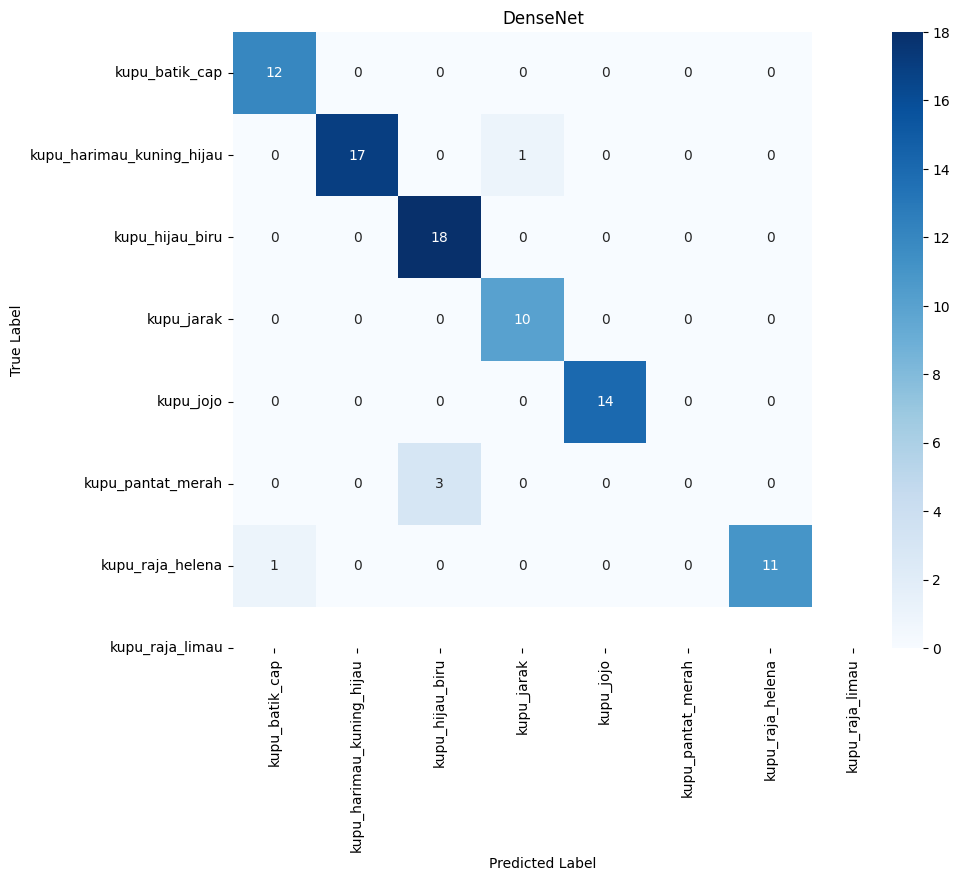

In [31]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('DenseNet')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [33]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    verbose=1,
    callbacks=[early_stopping]
)

end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds")

# Evaluasi model pada data validasi
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

# Evaluasi model pada data testing
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Prediksi pada data testing
Y_pred = model.predict(test_ds)
y_pred = np.argmax(Y_pred, axis=1)

# Mengambil data testing dari test_ds
def get_labels_and_predictions(ds):
    y_true = []
    y_pred = []
    for images, labels in ds:
        predictions = model.predict(images, batch_size=batch_size)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(predictions, axis=1))
    return np.array(y_true), np.array(y_pred)

# Dapatkan label dan prediksi dari data testing
y_true, y_pred = get_labels_and_predictions(test_ds)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print('Confusion Matrix')
print(conf_matrix)

# Classification Report
target_names = class_names
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=target_names))

# Plot Confusion Matrix menggunakan Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 52s 4s/step - accuracy: 0.9197 - loss: 0.3242 - val_accuracy: 0.9792 - val_loss: 0.2299
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 79s 4s/step - accuracy: 0.9435 - loss: 0.2136 - val_accuracy: 0.9792 - val_loss: 0.1875
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 85s 4s/step - accuracy: 0.9684 - loss: 0.0912 - val_accuracy: 0.9792 - val_loss: 0.1226
Training Time: 2003.85 seconds
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step - accuracy: 0.9648 - loss: 0.2194
Validation Accuracy: 96.88%
3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 1.0000 - loss: 0.0414
Test Accuracy: 100.00%
3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Confusion Matrix
[[22  0  0  0  0  0  0]
 [ 0 11  0  0  0  0  0]
 [ 0  0 14  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  0  0  0 14  0  0]
 [ 0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0 13]]
Classification Report


ValueError: Number of classes, 7, does not match size of target_names, 8. Try specifying the labels parameter

In [34]:
print("Unique classes in y_true:", np.unique(y_true))
print("Length of class_names:", len(class_names))
class_names = ['kupu_batik_cap', 'kupu_harimau_kuning_hijau', 'kupu_hijau_biru', 'kupu_jarak', 'kupu_jojo', 'kupu_pantat_merah', 'kupu_raja_helena', 'kupu_raja_limau']
print(classification_report(y_true, y_pred, labels=np.arange(len(class_names)), target_names=class_names))
from collections import Counter
print("Label distribution in y_true:", Counter(y_true))

Unique classes in y_true: [0 1 2 4 5 6 7]
Length of class_names: 8
                           precision    recall  f1-score   support

           kupu_batik_cap       1.00      1.00      1.00        22
kupu_harimau_kuning_hijau       1.00      1.00      1.00        11
          kupu_hijau_biru       1.00      1.00      1.00        14
               kupu_jarak       0.00      0.00      0.00         0
                kupu_jojo       1.00      1.00      1.00        12
        kupu_pantat_merah       1.00      1.00      1.00        14
         kupu_raja_helena       1.00      1.00      1.00         1
          kupu_raja_limau       1.00      1.00      1.00        13

                 accuracy                           1.00        87
                macro avg       0.88      0.88      0.88        87
             weighted avg       1.00      1.00      1.00        87

Label distribution in y_true: Counter({0: 22, 2: 14, 5: 14, 7: 13, 4: 12, 1: 11, 6: 1})


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/me

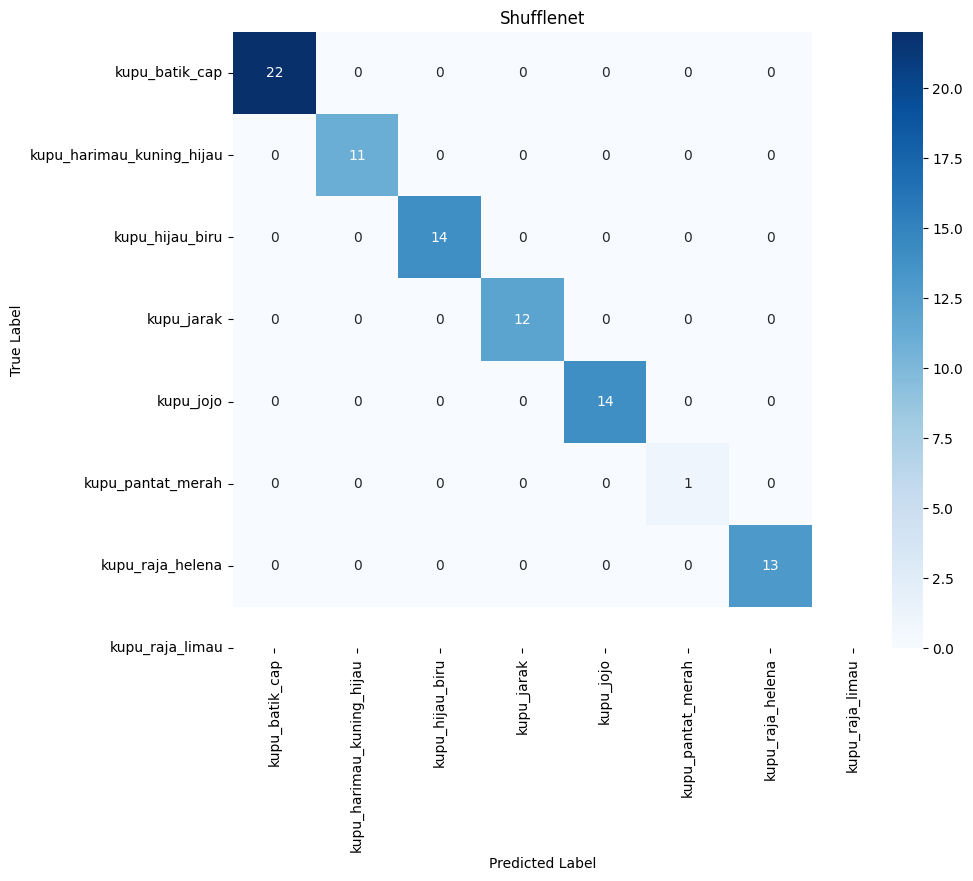

In [36]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Shufflenet')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [37]:
import tensorflow as tf
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, BatchNormalization, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Hyperparameter
learning_rate = 0.0001

# Menerapkan arsitektur NASNetMobile tanpa lapisan atas (Fully Connected Layer)
base_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False

# Tambahkan lapisan di atas model NASNetMobile
x = base_model.output
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(len(class_names), activation='softmax')(x)

# Buat model final
model = Model(inputs=base_model.input, outputs=x)

# Menampilkan summary dari model
model.summary()

# Compile Model
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callback Early Stopping
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=3,
                               restore_best_weights=True)

# Mengukur waktu komputasi
start_time = time.time()

# Train model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    verbose=1,
    callbacks=[early_stopping]
)

end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds")

# Evaluasi model pada data validasi
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

# Evaluasi model pada data testing
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Prediksi pada data testing
Y_pred = model.predict(test_ds)
y_pred = np.argmax(Y_pred, axis=1)

# Mengambil data testing dari test_ds
def get_labels_and_predictions(ds):
    y_true = []
    y_pred = []
    for images, labels in ds:
        predictions = model.predict(images, batch_size=batch_size)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(predictions, axis=1))
    return np.array(y_true), np.array(y_pred)

# Dapatkan label dan prediksi dari data testing
y_true, y_pred = get_labels_and_predictions(test_ds)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print('Confusion Matrix')
print(conf_matrix)

# Classification Report
target_names = class_names
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=target_names))

# Plot Confusion Matrix menggunakan Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


19993432/19993432 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv1 (Conv2D)       │ (None, 111, 111, 32)   │            864 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn1                  │ (None, 111, 111, 32)   │            128 │ stem_conv1[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 111, 111, 32)   │              0 │ stem_bn1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reduction_conv_1_stem_1   │ (None, 111, 111, 11)   │            352 │ activation[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reduction_bn_1_stem_1     │ (None, 111, 111, 11)   │             44 │ reduction_conv_1_stem… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 111, 111, 11)   │              0 │ reduction_bn_1_stem_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 111, 111, 32)   │              0 │ stem_bn1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_pad_red… │ (None, 115, 115, 11)   │              0 │ activation_1[0][0]     │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_pad_red… │ (None, 117, 117, 32)   │              0 │ activation_3[0][0]     │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_reducti… │ (None, 56, 56, 11)     │            396 │ separable_conv_1_pad_… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_reducti… │ (None, 56, 56, 11)     │          1,920 │ separable_conv_1_pad_… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_bn_redu… │ (None, 56, 56, 11)     │             44 │ separable_conv_1_redu… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_bn_redu… │ (None, 56, 56, 11)     │             44 │ separable_conv_1_redu… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activat

 Total params: 17,859,100 (68.13 MB)

 Trainable params: 13,485,896 (51.44 MB)

 Non-trainable params: 4,373,204 (16.68 MB)

Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 112s 5s/step - accuracy: 0.2483 - loss: 2.0144 - val_accuracy: 0.7396 - val_loss: 1.3014
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 49s 4s/step - accuracy: 0.6317 - loss: 1.3336 - val_accuracy: 0.8021 - val_loss: 0.8781
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 83s 4s/step - accuracy: 0.7177 - loss: 1.0140 - val_accuracy: 0.8333 - val_loss: 0.8542
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 52s 4s/step - accuracy: 0.8160 - loss: 0.7431 - val_accuracy: 0.9271 - val_loss: 0.5063
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - accuracy: 0.8216 - loss: 0.5839 - val_accuracy: 0.9271 - val_loss: 0.4013
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - accuracy: 0.8638 - loss: 0.4768 - val_accuracy: 0.9479 - val_loss: 0.3477
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - accuracy: 0.9055 - loss: 0.4037 - val_accuracy: 0.9375 - val_loss: 0.4115
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 83s 4s/step - accuracy: 0.9167 - loss: 0.3036 - val_accuracy: 0.9479 - val_loss

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
Confusion Matrix
[[12  0  0  0  0  0  0]
 [ 0 18  0  0  0  0  0]
 [ 2  0 11  0  3  0  0]
 [ 0  0  1 14  0  0  0]
 [ 0  0  0  0 11  0  0]
 [ 0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0 14]]
Classification Report


ValueError: Number of classes, 7, does not match size of target_names, 8. Try specifying the labels parameter

In [38]:
print("Unique classes in y_true:", np.unique(y_true))
print("Length of class_names:", len(class_names))
class_names = ['kupu_batik_cap', 'kupu_harimau_kuning_hijau', 'kupu_hijau_biru', 'kupu_jarak', 'kupu_jojo', 'kupu_pantat_merah', 'kupu_raja_helena', 'kupu_raja_limau']
print(classification_report(y_true, y_pred, labels=np.arange(len(class_names)), target_names=class_names))
from collections import Counter
print("Label distribution in y_true:", Counter(y_true))

Unique classes in y_true: [0 1 2 4 5 6 7]
Length of class_names: 8
                           precision    recall  f1-score   support

           kupu_batik_cap       0.86      1.00      0.92        12
kupu_harimau_kuning_hijau       1.00      1.00      1.00        18
          kupu_hijau_biru       0.92      0.69      0.79        16
               kupu_jarak       0.00      0.00      0.00         0
                kupu_jojo       0.93      0.93      0.93        15
        kupu_pantat_merah       0.79      1.00      0.88        11
         kupu_raja_helena       0.00      0.00      0.00         1
          kupu_raja_limau       1.00      1.00      1.00        14

                 accuracy                           0.92        87
                macro avg       0.69      0.70      0.69        87
             weighted avg       0.91      0.92      0.91        87

Label distribution in y_true: Counter({1: 18, 2: 16, 4: 15, 7: 14, 0: 12, 5: 11, 6: 1})


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/me

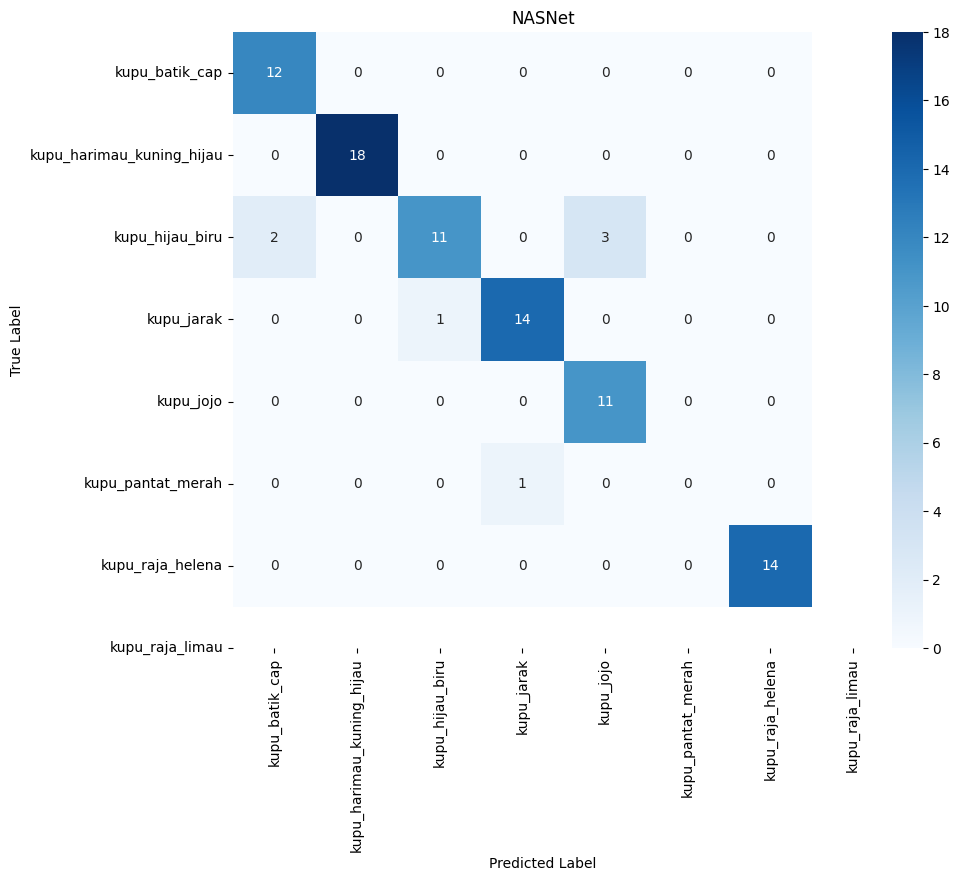

In [40]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('NASNet')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()